In [1]:
import pandas as pd
import numpy as np

import os

%pylab inline

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('Magic record - Sheet1.csv')

data.columns = 'Me Opponent Win Rank Hand Mulligans del1 del2'.split()

del data['Hand']
del data['Mulligans']
del data['del1']
del data['del2']

data.tail()

,Me,Opponent,Win,Rank
467,UG,UB,0,Bronze 1
468,UG,R,1,Bronze 1
469,UG,RG,1,Bronze 1
470,UG,WB,0,Bronze 1
471,UG,BR,1,Bronze 1


In [3]:
# How many times I've played each color combo
data.groupby('Me').count().sort_values('Opponent', ascending=False)[['Opponent']]

,Opponent
Me,
BG,64
RG,45
R,43
WG,37
BR,36
UR,35
UB,34
UG,33
G,24


In [4]:
data['Me_W'] = np.where(data['Me'].str.contains('W'), 1, 0)
data['Me_U'] = np.where(data['Me'].str.contains('U'), 1, 0)
data['Me_B'] = np.where(data['Me'].str.contains('B'), 1, 0)
data['Me_R'] = np.where(data['Me'].str.contains('R'), 1, 0)
data['Me_G'] = np.where(data['Me'].str.contains('G'), 1, 0)

data['Opponent_W'] = np.where(data['Opponent'].str.contains('W'), 1, 0)
data['Opponent_U'] = np.where(data['Opponent'].str.contains('U'), 1, 0)
data['Opponent_B'] = np.where(data['Opponent'].str.contains('B'), 1, 0)
data['Opponent_R'] = np.where(data['Opponent'].str.contains('R'), 1, 0)
data['Opponent_G'] = np.where(data['Opponent'].str.contains('G'), 1, 0)

rank = np.where(data['Rank'] == 'Bronze 1', 1, np.nan)
rank = np.where(data['Rank'] == 'Silver 4', 2, rank)
rank = np.where(data['Rank'] == 'Silver 3', 3, rank)

data['My_colors_ct'] = data['Me'].apply(len)
data['Opponent_colors_ct'] = data['Opponent'].apply(len)

data['Rank'] = pd.Series(rank)

In [5]:
data.groupby('Me').mean()['Win'].sort_values()

Me
W      0.000000
WUG    0.000000
WBG    0.200000
WUR    0.272727
WBR    0.285714
GW     0.333333
B      0.380952
UR     0.400000
UBR    0.434783
G      0.458333
UG     0.484848
BRG    0.500000
WR     0.500000
BR     0.555556
WUB    0.555556
BG     0.562500
WG     0.567568
RG     0.577778
UBG    0.583333
UB     0.617647
R      0.651163
WB     0.666667
WU     1.000000
Name: Win, dtype: float64

In [6]:
data.groupby('Opponent').mean()['Win'].sort_values()

Opponent
WBG      0.000000
UG       0.200000
UBRG     0.333333
WR       0.400000
BG       0.407407
W        0.411765
RG       0.437500
UR       0.444444
WUBRG    0.500000
WU       0.500000
WRG      0.500000
WUR      0.500000
UBG      0.500000
R        0.500000
G        0.510638
BR       0.536585
WB       0.538462
B        0.538462
UB       0.555556
BRG      0.600000
UBR      0.600000
U        0.666667
WG       0.684211
WUB      0.714286
WUG      0.833333
WBR      1.000000
BW       1.000000
WUBG     1.000000
Name: Win, dtype: float64

In [7]:
del data['Me']
del data['Opponent']

data = pd.get_dummies(data)

In [8]:
x = data.drop('Win', axis=1).dropna(axis=1)
y = data['Win'].dropna()

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

clf = DecisionTreeClassifier()
kf = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': np.arange(2,7),
    'min_samples_leaf': np.arange(1,13),
    'min_samples_split': np.arange(2,13),
    
}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

cv.mean(), cv.std()

(0.4796253418349648, 0.036597040716970695)

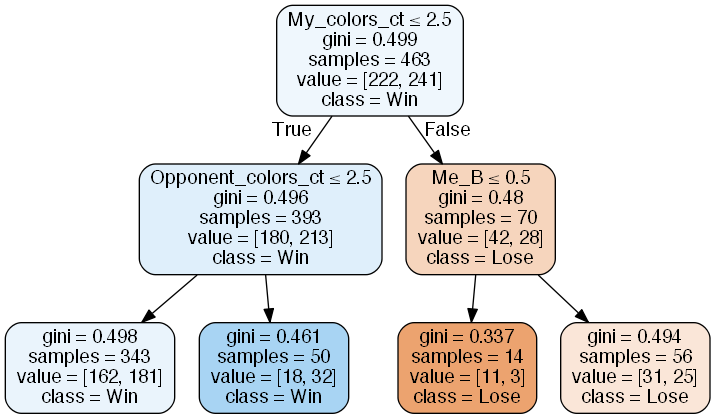

In [13]:
from sklearn.tree import export_graphviz

clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(x,y)
from IPython.display import Image  
import pydotplus

dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Lose', 'Win'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

clf = LogisticRegression()
kf = StratifiedKFold()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [.0001, .001, .01, .1, 1, 2, .5]
}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

cv.mean(), cv.std()

(0.520713930044916, 0.01919419808505379)

In [72]:
pd.DataFrame(clf.coef_, columns=x.columns).T.sort_values(0)

,0
Me_W,0.000000
Me_U,0.000000
Me_B,0.000000
Me_R,0.000000
Me_G,0.000000
Opponent_W,0.000000
Opponent_U,0.000000
Opponent_B,0.000000
Opponent_R,0.000000
Opponent_G,0.000000


In [73]:
data.to_csv('record_proc.csv')

In [76]:
land_count = []

for trial in range(10000):
    deck = []
    lands = 29
    cards = 60 - lands

    for i in range(lands):
        deck += ['land']
    for i in range(cards):
        deck += ['cards']

    shuffle(deck)

    lands_drawn = 0
    turn = 4

    for i in range(7 + turn):
        new = deck.pop()
        if new == 'land':
            lands_drawn += 1
    land_count += [lands_drawn]
    
land_count = pd.Series(land_count)

In [77]:
len(land_count[land_count >= 4])/len(land_count)

0.8906

# Best colors?

In [117]:
data = data[data.Me != data.Opponent]

me = data['Me'].values.tolist()
them = data['Opponent'].values.tolist()

colors = me + them
colors = pd.Series(colors)

colors = dict(colors.value_counts())

In [119]:
winners = pd.Series(np.where(data['Win'] == 1, data['Me'], data['Opponent']))
winners = dict(winners.value_counts())

In [120]:
record = {}

for i in winners.keys():
    record[i] = winners[i]/colors[i]

In [121]:
pd.DataFrame([record]).T.sort_values(0, ascending=False)

,0
RG,0.607143
R,0.588235
WR,0.583333
UB,0.568182
BG,0.566265
UBG,0.555556
UG,0.548387
W,0.542857
WB,0.525000
WUBRG,0.500000
